Importando as dependências.

In [ ]:
import cv2
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
from keras import backend as K
import tensorflow as tf


Carregando o modelo.

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/d.IAgnostica - Livros/2 - segundos modelos (aprimoramentos)/model-13-0.9788-27092023.h5'
model = load_model(MODEL_PATH);

Carregando e redimencionando a imagem.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 64)      2

Criando o modelo para gerar o mapa de calor.

In [ ]:
gap_weights = model.layers[-1].get_weights()[0]
print(gap_weights.shape)

cam_model  = Model(inputs=[model.input], outputs=[model.layers[-8].output, model.output])
cam_model.summary()

(128, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)   

In [ ]:
def show_cam(image_value, features, results):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 224 x 224
    features (array) -- features of the image, shape (1, 7, 7, 256)
    results (array) -- output of the sigmoid layer
  '''

  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction = results[0]

  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:,0]

  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (224/7, 224/7, 1), order=2)
  #spline interpolation of order = 2 (G search)

  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features, class_activation_weights)

  # visualize the results
  print(f'sigmoid output: {results}')
  print(f"prediction: {'NORMAL' if round(results[0][0]) else 'PNEUMONIA'}")

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
  ax1.imshow(cam_output, cmap='jet', alpha=0.5)
  ax1.imshow(IMG, alpha=0.5)
  ax1.set_title('Imagem de calor')

  ax2.imshow(IMG)
  ax2.set_title('Imagem original')

  plt.tight_layout()
  plt.show()

#Given a tensor input, this operation returns a tensor of the same type with all dimensions of size 1 removed. - tf.squeeze

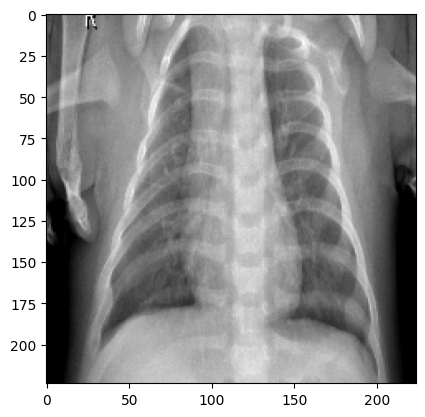

In [ ]:
IMG_PATH = '/content/drive/MyDrive/d.IAgnostica - Livros/PNEUMONIA/PNEUMONIA/chest_xray distribuida/test/NORMAL/IM-0073-0001.jpeg'
IMG_SIZE = 224
label = 0
classes = ['PNEUMONIA', 'NORMAL']

IMG = cv2.resize(cv2.imread(IMG_PATH), (IMG_SIZE, IMG_SIZE))

img_teste = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)
img_teste = cv2.resize(img_teste, (IMG_SIZE, IMG_SIZE))

img_teste = np.array(img_teste) / 255
img_teste = img_teste.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

plt.imshow(IMG)

In [ ]:
preds = model.predict(img_teste)

prediction = 0 if preds[0] <= 0.5 else 1
print(f'Prediction: {classes[prediction]}')

1/1 [==============================] - 0s 58ms/step
Prediction: NORMAL


1/1 [==============================] - 0s 84ms/step
sigmoid output: [[0.9277679]]
prediction: NORMAL


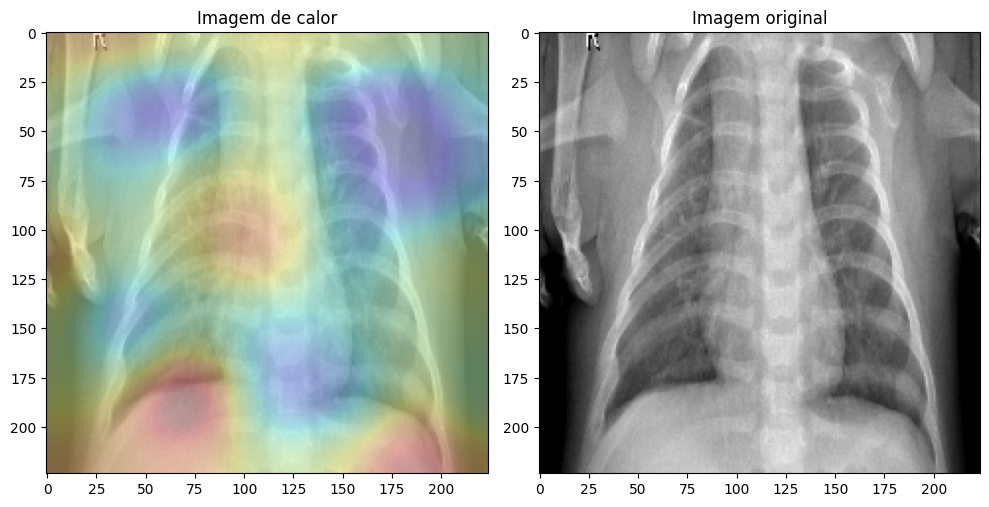

In [ ]:
features, results = cam_model.predict(img_teste)
show_cam(img_teste, features, results)